Descargando datos...


[*********************100%***********************]  4 of 4 completed
<ipython-input-1-81ea3508d7c4>:27: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


Datos descargados:
Ticker         GGAL.BA          ^DJI        ^GSPC        ^IXIC
Date                                                          
2020-01-02  115.791817  28868.800781  3257.850098  9092.190430
2020-01-03  113.720749  28634.880859  3234.850098  9020.769531
2020-01-06  117.580475  28703.380859  3246.280029  9071.469727
2020-01-07  116.733223  28583.679688  3237.179932  9068.580078
2020-01-08  118.521873  28745.089844  3253.050049  9129.240234

Valores nulos por símbolo:
Ticker
GGAL.BA    74
^DJI       33
^GSPC      33
^IXIC      33
dtype: int64

Retornos diarios (primeras filas):
Ticker       GGAL.BA      ^DJI     ^GSPC     ^IXIC
Date                                              
2020-01-03 -0.017886 -0.008103 -0.007060 -0.007855
2020-01-06  0.033940  0.002392  0.003533  0.005620
2020-01-07 -0.007206 -0.004170 -0.002803 -0.000319
2020-01-08  0.015323  0.005647  0.004902  0.006689
2020-01-09  0.035346  0.007369  0.006655  0.008127

Volatilidad diaria (primeras filas):
Ticke

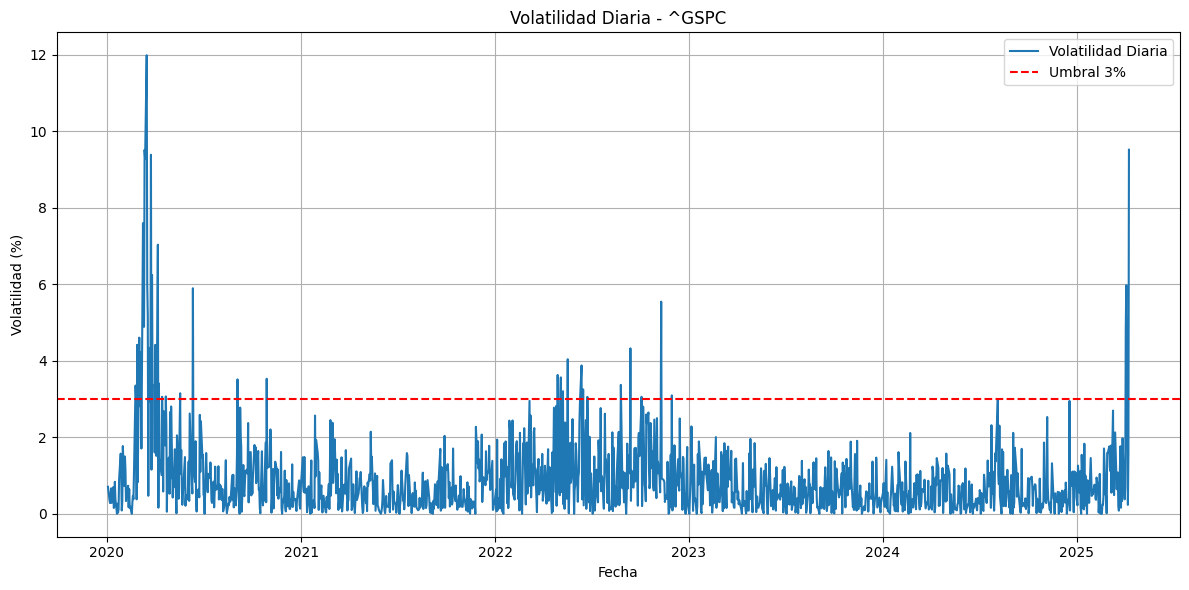

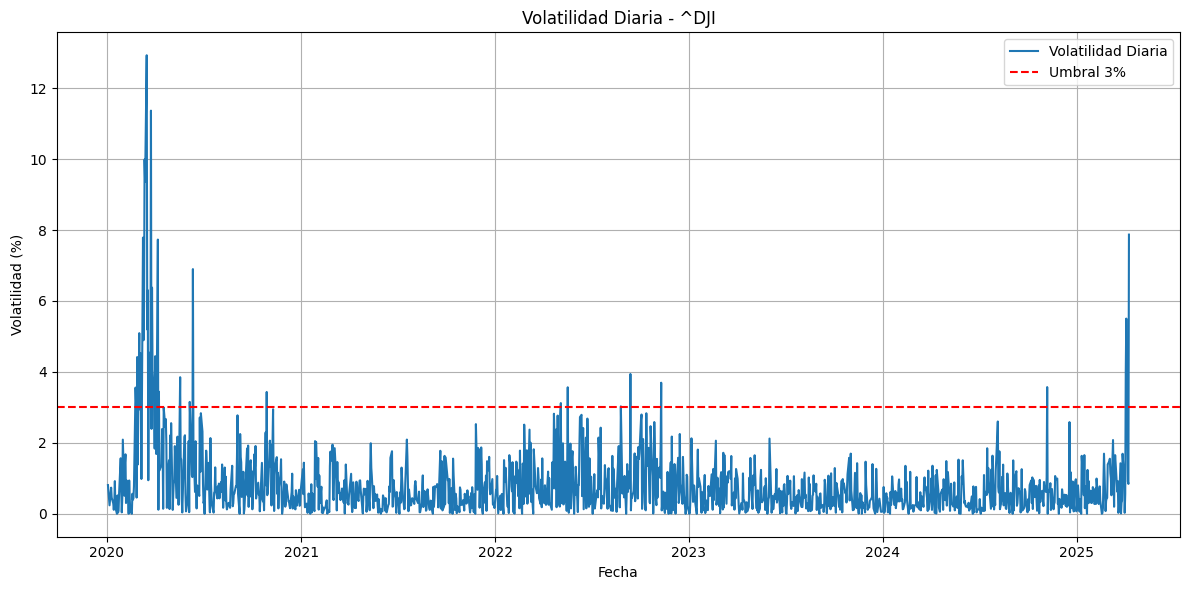

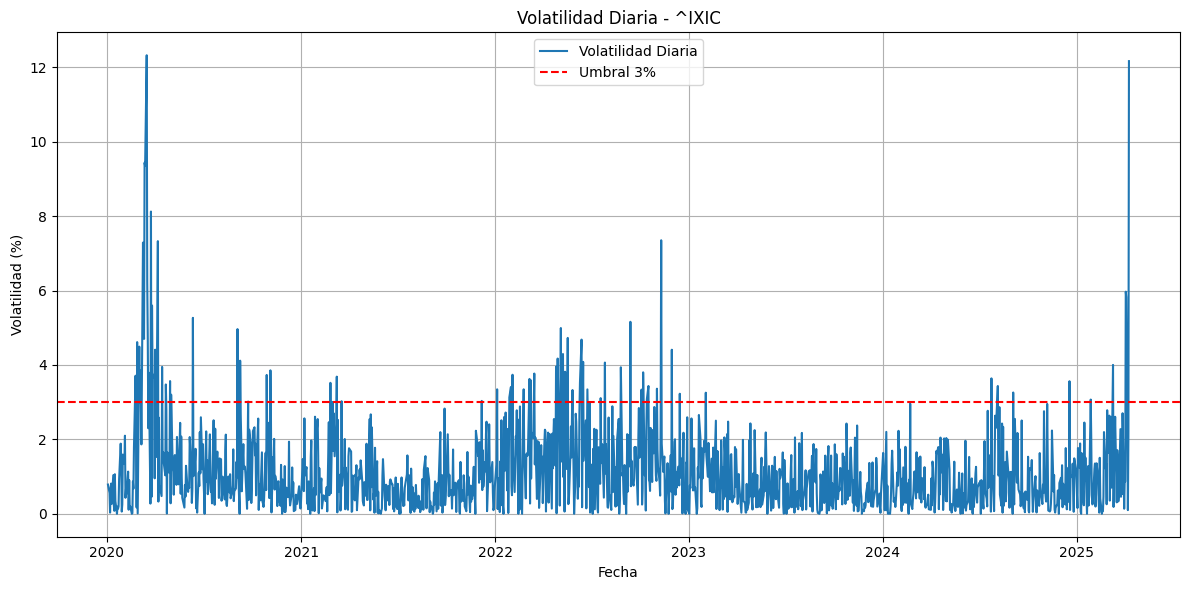

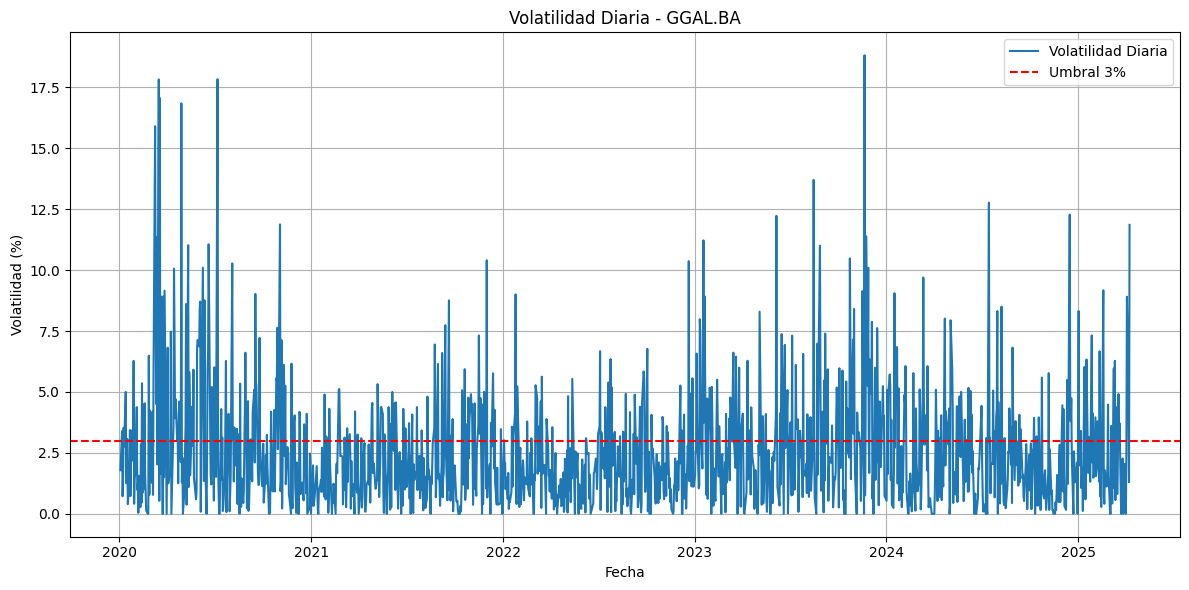


=== ^GSPC ===

Días con volatilidad > 3%:
            Volatilidad  Retorno Día Anterior  Retorno Día Actual  Retorno Día Siguiente
Date                                                                                    
2020-02-24     3.351363             -1.051810           -3.351363              -3.028000
2020-02-25     3.028000             -3.351363           -3.028000              -0.377854
2020-02-27     4.416324             -0.377854           -4.416324              -0.823834
2020-03-02     4.603923             -0.823834            4.603923              -2.810790
2020-03-04     4.220259             -2.810790            4.220259              -3.392208
2020-03-05     3.392208              4.220259           -3.392208              -1.705385
2020-03-09     7.596970             -1.705385           -7.596970               4.939631
2020-03-10     4.939631             -7.596970            4.939631              -4.886845
2020-03-11     4.886845              4.939631           -4.886845  

In [ ]:
# Necesario para mostrar gráficos en Colab
%matplotlib inline
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Definir los símbolos y el período
symbols = ['^GSPC', '^DJI', '^IXIC', 'GGAL.BA']
start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Descargar datos con manejo de errores
print("Descargando datos...")
data = yf.download(symbols, start=start_date, end=end_date, auto_adjust=True)['Close']

# Verificar datos descargados
if data.empty:
    raise ValueError("No se pudieron descargar los datos. Verifica los símbolos o la conexión.")
print("Datos descargados:")
print(data.head())
print("\nValores nulos por símbolo:")
print(data.isnull().sum())

# Calcular retornos diarios y eliminar NaN iniciales
returns = data.pct_change().dropna()
print("\nRetornos diarios (primeras filas):")
print(returns.head())

# Calcular volatilidades (desviación estándar)
# Para volatilidad diaria, usamos el valor absoluto del retorno como proxy
daily_vol = returns.abs() * 100  # En porcentaje, usando valor absoluto
monthly_vol = returns.rolling(window=21).std() * 100 * np.sqrt(21)
annual_vol = returns.rolling(window=252).std() * 100 * np.sqrt(252)

print("\nVolatilidad diaria (primeras filas):")
print(daily_vol.head())

# Identificar días con volatilidad > 3%
high_vol_days = daily_vol > 3

# Crear diccionario para almacenar resultados
results = {}

# Análisis y gráficos por símbolo
for symbol in symbols:
    # Limpiar datos de volatilidad diaria para este símbolo
    symbol_daily_vol = daily_vol[symbol].dropna()

    if symbol_daily_vol.empty:
        print(f"Advertencia: No hay datos válidos de volatilidad para {symbol}")
        print(f"Retornos para {symbol}:")
        print(returns[symbol].head())
        continue

    # Días de alta volatilidad
    high_vol_data = pd.DataFrame({
        'Volatilidad': symbol_daily_vol[high_vol_days[symbol]],
        'Retorno Día Anterior': returns[symbol].shift(1)[high_vol_days[symbol]] * 100,
        'Retorno Día Actual': returns[symbol][high_vol_days[symbol]] * 100,
        'Retorno Día Siguiente': returns[symbol].shift(-1)[high_vol_days[symbol]] * 100
    }).dropna()

    # Días de máxima y mínima volatilidad
    try:
        max_vol_day = symbol_daily_vol.idxmax()
        min_vol_day = symbol_daily_vol.idxmin()

        if pd.isna(max_vol_day) or pd.isna(min_vol_day):
            raise ValueError("Fecha inválida encontrada")

        max_vol_value = symbol_daily_vol.loc[max_vol_day]
        min_vol_value = symbol_daily_vol.loc[min_vol_day]
    except (ValueError, KeyError) as e:
        print(f"Error al calcular max/min para {symbol}: {e}")
        max_vol_day, max_vol_value = symbol_daily_vol.index[0], symbol_daily_vol.iloc[0]
        min_vol_day, min_vol_value = symbol_daily_vol.index[0], symbol_daily_vol.iloc[0]

    results[symbol] = {
        'high_vol_data': high_vol_data,
        'max_vol': (max_vol_day, max_vol_value),
        'min_vol': (min_vol_day, min_vol_value)
    }

    # Crear y mostrar gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(symbol_daily_vol.index, symbol_daily_vol, label='Volatilidad Diaria')
    plt.axhline(y=3, color='r', linestyle='--', label='Umbral 3%')
    plt.title(f'Volatilidad Diaria - {symbol}')
    plt.xlabel('Fecha')
    plt.ylabel('Volatilidad (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Imprimir resultados
for symbol in symbols:
    if symbol not in results:
        continue
    print(f"\n=== {symbol} ===")
    print("\nDías con volatilidad > 3%:")
    print(results[symbol]['high_vol_data'].to_string())
    print(f"\nDía de máxima volatilidad: {results[symbol]['max_vol'][0]} - "
          f"{results[symbol]['max_vol'][1]:.2f}%")
    print(f"Día de mínima volatilidad: {results[symbol]['min_vol'][0]} - "
          f"{results[symbol]['min_vol'][1]:.2f}%")
    print(f"\nVolatilidad promedio:")
    print(f"Diaria: {daily_vol[symbol].mean():.2f}%")
    print(f"Mensual: {monthly_vol[symbol].mean():.2f}%")
    print(f"Anual: {annual_vol[symbol].mean():.2f}%")

# Guardar datos en CSV (opcional en Colab)
daily_vol.to_csv('volatilidad_diaria.csv')
monthly_vol.to_csv('volatilidad_mensual.csv')
annual_vol.to_csv('volatilidad_anual.csv')

print("\nLos datos se han guardado en archivos CSV.")